In [1]:
import pandas as pd
import numpy as np
import math
import time
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor, XGBClassifier

from numpy.ma import MaskedArray
import sklearn.utils.fixes

sklearn.utils.fixes.MaskedArray = MaskedArray

import skopt

from skopt import gp_minimize, dump, load
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from scipy.stats import linregress

import pdfplumber
import os
import csv
import datetime

C:\Users\IntegralBery\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
print(os.getcwd())
csvs = [x for x in os.listdir(os.getcwd()+'\data') if "clusters.csv" in x and int(x[:4]) < 2004]
for csv in csvs:
    print(csv)
dates = []
for date in csvs:
    dates.append(datetime.datetime(int("20"+date[:2]), int(date[2:4]), int(date[4:6])))

intervals = []
for i in range(1, len(dates)):
    diff = (dates[i]-dates[i-1]).days
    if diff == 7:
        intervals.append((dates[i-1].date()))
        
        
for i in range(2, len(dates)):
    diff = (dates[i]-dates[i-2]).days
    if diff == 7:
        intervals.append((dates[i-2].date()))
intervals.sort()
print(len(intervals))
for date in intervals:
    print(date)

C:\Users\IntegralBery\Dropbox\Y3S2\CS3244\Proj\Prototype
130523-clusters.csv
130527-clusters.csv
130611-clusters.csv
130617-clusters.csv
130624-clusters.csv
130704-clusters.csv
130708-clusters.csv
130718-clusters.csv
130726-clusters.csv
130807-clusters.csv
130813-clusters.csv
130821-clusters.csv
130830-clusters.csv
130906-clusters.csv
130909-clusters.csv
130913-clusters.csv
131030-clusters.csv
131101-clusters.csv
131104-clusters.csv
131111-clusters.csv
131118-clusters.csv
131122-clusters.csv
131125-clusters.csv
131202-clusters.csv
131206-clusters.csv
131209-clusters.csv
131213-clusters.csv
131216-clusters.csv
131224-clusters.csv
131227-clusters.csv
131230-clusters.csv
131231-clusters.csv
140103-clusters.csv
140106-clusters.csv
140110-clusters.csv
140114-clusters.csv
140117-clusters.csv
140120-clusters.csv
140124-clusters.csv
140127-clusters.csv
140128-clusters.csv
140130-clusters.csv
140203-clusters.csv
140204-clusters.csv
140206-clusters.csv
140207-clusters.csv
140210-clusters.csv
140

In [11]:
print(intervals[-1]+datetime.timedelta(7) - intervals[0]-datetime.timedelta(20))

2455 days, 0:00:00


In [39]:
target_advance_days = 7
training_previous_days = 20
last_date = intervals[-1]+datetime.timedelta(target_advance_days)
first_date = intervals[0]-datetime.timedelta(training_previous_days)

stations = ['Admiralty', 'Ang Mo Kio', 'Changi', 'Choa Chu Kang (South)', 'Clementi', 'East Coast Parkway', 'Jurong Island',
            'Jurong (West)', 'Marina Barrage', 'Newton', 'Pasir Panjang', 'Paya Lebar', 'Pulau Ubin', 'Seletar',
            'Sembawang', 'Semakau Island', 'Sentosa Island', 'Tai Seng', 'Tuas South']
df = pd.read_csv('Dengue_Weather_Temp.csv')
df = (df.drop(df.loc[~df['Station'].isin(stations)].index)
        .drop(df.columns[[0, 6, 7, 8, 9, 12, 13]], axis=1)
     )
#df = df.drop(df.loc[(df['Maximum Temperature (°C)'] == '-') | (df['Maximum Temperature (°C)'] == '—')].index)
df['Date'] = (pd.to_datetime(df[['Year', 'Month', 'Day']])
                .apply(lambda x: x.date()))
df = (df.drop(df.loc[df['Date'] < first_date].index)
        .drop(df.loc[df['Date'] > last_date].index)
     )


numerical_cols = ['Daily Rainfall Total (mm)', 'Maximum Temperature (°C)', 'Minimum Temperature (°C)']
df[numerical_cols] = df[numerical_cols].apply(lambda x: pd.to_numeric(x, errors="coerce"))

#df = df.drop(['Year', 'Day'], axis=1)

def daterange(end_date, days):
    for n in range(days-1,-1,-1):
        yield end_date - datetime.timedelta(n)

for date in daterange(last_date, (last_date - first_date).days):
    curr_date = df[df['Date']==date]
    for station in stations:
        if not station in curr_date['Station'].to_list():
            print(station, date)
            df.loc[-1] = [station, date.year, date.month, date.day, np.nan, np.nan, np.nan, np.nan, date]
            df.index = df.index + 1
      

for index, row in df.iterrows():
    for label in numerical_cols:
        if np.isnan(row[label]):
            df.loc[index, label] = df[df['Date']==row['Date']][label].mean()

#df = pd.get_dummies(df, columns=['Month', 'Station'])         

df = (df.sort_values(by=['Date', 'Station'])
        .reset_index(drop=True)
     )           
display(df)


Pulau Ubin 2013-11-01
Pulau Ubin 2013-11-02
Pulau Ubin 2013-11-03
Pulau Ubin 2013-11-04
Pulau Ubin 2013-11-05
Pulau Ubin 2013-11-06
Pulau Ubin 2013-11-07
Pulau Ubin 2013-11-08
Pulau Ubin 2013-11-09
Pulau Ubin 2013-11-10
Pulau Ubin 2013-11-11
Pulau Ubin 2013-11-12
Pulau Ubin 2013-11-13
Pulau Ubin 2013-11-14
Pulau Ubin 2013-11-15
Pulau Ubin 2013-11-16
Pulau Ubin 2013-11-17
Pulau Ubin 2013-11-18
Pulau Ubin 2013-11-19
Pulau Ubin 2013-11-20
Pulau Ubin 2013-11-21
Pulau Ubin 2013-11-22
Pulau Ubin 2013-11-23
Pulau Ubin 2013-11-24
Pulau Ubin 2013-11-25
Pulau Ubin 2013-11-26
Pulau Ubin 2013-11-27
Pulau Ubin 2013-11-28
Pulau Ubin 2013-11-29
Pulau Ubin 2013-11-30
Pulau Ubin 2013-12-01
Semakau Island 2013-12-01
Pulau Ubin 2013-12-02
Semakau Island 2013-12-02
Pulau Ubin 2013-12-03
Semakau Island 2013-12-03
Pulau Ubin 2013-12-04
Semakau Island 2013-12-04
Pulau Ubin 2013-12-05
Semakau Island 2013-12-05
Pulau Ubin 2013-12-06
Semakau Island 2013-12-06
Pulau Ubin 2013-12-07
Semakau Island 2013-12-07
Pula

Semakau Island 2014-11-17
Jurong (West) 2014-11-18
Semakau Island 2014-11-18
Jurong (West) 2014-11-19
Semakau Island 2014-11-19
Jurong (West) 2014-11-20
Semakau Island 2014-11-20
Jurong (West) 2014-11-21
Semakau Island 2014-11-21
Jurong (West) 2014-11-22
Semakau Island 2014-11-22
Jurong (West) 2014-11-23
Semakau Island 2014-11-23
Jurong (West) 2014-11-24
Semakau Island 2014-11-24
Jurong (West) 2014-11-25
Semakau Island 2014-11-25
Jurong (West) 2014-11-26
Semakau Island 2014-11-26
Jurong (West) 2014-11-27
Semakau Island 2014-11-27
Jurong (West) 2014-11-28
Semakau Island 2014-11-28
Jurong (West) 2014-11-29
Semakau Island 2014-11-29
Jurong (West) 2014-11-30
Semakau Island 2014-11-30
Jurong (West) 2014-12-01
Jurong (West) 2014-12-02
Jurong (West) 2014-12-03
Jurong (West) 2014-12-04
Jurong (West) 2014-12-05
Jurong (West) 2014-12-06
Jurong (West) 2014-12-07
Jurong (West) 2014-12-08
Jurong (West) 2014-12-09
Jurong (West) 2014-12-10
Jurong (West) 2014-12-11
Jurong (West) 2014-12-12
Jurong (Wes

Sembawang 2018-12-15
Sembawang 2018-12-16
Sembawang 2018-12-22
Sembawang 2018-12-23
Sembawang 2018-12-25
Sembawang 2018-12-29
Sembawang 2018-12-30
Sembawang 2019-01-01
Sembawang 2019-01-05
Sembawang 2019-01-06
Sembawang 2019-01-12
Sembawang 2019-01-13
Sembawang 2019-01-19
Sembawang 2019-01-20
Sembawang 2019-01-26
Sembawang 2019-01-27
Sembawang 2019-02-02
Sembawang 2019-02-03
Sembawang 2019-02-05
Sembawang 2019-02-06
Sembawang 2019-02-09
Sembawang 2019-02-10
Sembawang 2019-02-16
Sembawang 2019-02-17
Sembawang 2019-02-23
Sembawang 2019-02-24
Sembawang 2019-03-02
Sembawang 2019-03-03
Sembawang 2019-03-09
Sembawang 2019-03-10
Sembawang 2019-03-16
Sembawang 2019-03-17
Sembawang 2019-03-23
Sembawang 2019-03-24
Paya Lebar 2019-03-28
Sembawang 2019-03-30
Sembawang 2019-03-31
Sembawang 2019-04-06
Sembawang 2019-04-07
Sembawang 2019-04-13
Sembawang 2019-04-14
Sembawang 2019-04-19
Sembawang 2019-04-20
Sembawang 2019-04-21
Sembawang 2019-04-27
Sembawang 2019-04-28
Sembawang 2019-05-01
Sembawang 20

,Station,Year,Month,Day,Daily Rainfall Total (mm),Maximum Temperature (°C),Minimum Temperature (°C),Dengue Clusters,Date
0,Admiralty,2013.0,5.0,28.0,0.000000,32.70000,25.6,0.0,2013-05-28
1,Ang Mo Kio,2013.0,5.0,28.0,0.000000,33.10000,25.9,0.0,2013-05-28
2,Changi,2013.0,5.0,28.0,0.000000,32.50000,25.5,0.0,2013-05-28
3,Choa Chu Kang (South),2013.0,5.0,28.0,0.000000,32.80000,25.5,0.0,2013-05-28
4,Clementi,2013.0,5.0,28.0,0.000000,33.10000,25.7,0.0,2013-05-28
...,...,...,...,...,...,...,...,...,...
47419,Semakau Island,2020.0,3.0,27.0,8.177778,33.70625,25.7,0.0,2020-03-27
47420,Sembawang,2020.0,3.0,27.0,3.000000,34.20000,24.2,13.0,2020-03-27
47421,Sentosa Island,2020.0,3.0,27.0,8.000000,31.90000,26.1,3.0,2020-03-27
47422,Tai Seng,2020.0,3.0,27.0,0.000000,35.00000,27.6,235.0,2020-03-27


In [41]:
#df.to_csv('dataset.csv')

In [36]:
for i in range(1, 13):
    print([round(np.sin(2*np.pi*i/12),5), round(np.cos(2*np.pi*i/12),5)])

[0.5, 0.86603]
[0.86603, 0.5]
[1.0, 0.0]
[0.86603, -0.5]
[0.5, -0.86603]
[0.0, -1.0]
[-0.5, -0.86603]
[-0.86603, -0.5]
[-1.0, -0.0]
[-0.86603, 0.5]
[-0.5, 0.86603]
[-0.0, 1.0]


In [56]:
latlong = {"Paya Lebar": (1.3524, 103.9007), "Tengah": (1.3858, 103.7114), "Changi": (1.3678, 103.9826),
           "Seletar": (1.4166, 103.8654), "Tai Seng": (1.3399, 103.8878), "Jurong (West)": (1.3455, 103.6806),
          "Ang Mo Kio": (1.3764, 103.8492), "Clementi": (1.3337, 103.7768), "Admiralty": (1.4439, 103.7854),
          "Sentosa Island": (1.2500, 103.8279), "Sembawang": (1.4252, 103.8202), "Semakau Island": (1.1890, 103.7680),
          "Pulau Ubin": (1.4168, 103.9673), "East Coast Parkway": (1.3134, 103.9619), "Marina Barrage": (1.2799, 103.8703),
          "Newton": (1.3106, 103.8365), "Tuas South": (1.2938, 103.6184), "Pasir Panjang": (1.2810, 103.7540),
          "Jurong Island": (1.2542, 103.6741), "Choa Chu Kang (South)": (1.3729, 103.7224)}

df = pd.read_csv('dataset2.csv')
df = df.drop(df.columns[[0]], axis=1)

#for index, row in df.iterrows():
#    if np.isnan(row["Latitude"]):
#        df.loc[index, "Latitude"] = latlong[row["Station"]][0]
#    if np.isnan(row["Longitude"]):
#        df.loc[index, "Longitude"] = latlong[row["Station"]][1]
#for index, row in df.iterrows():
#    print([np.sin(2*np.pi*row['Month']/12), np.cos(2*np.pi*row['Month']/12)])

df['MonthSin'], df['MonthCos'] = zip(*df['Month'].map(lambda x: [round(np.sin(2*np.pi*x/12),5), round(np.cos(2*np.pi*x/12),5)]))
df = df.drop(df.columns[[0,1]], axis=1)
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.date())
display(df)
#df.to_csv('dataset2.csv')

,Daily Rainfall Total (mm),Maximum Temperature (°C),Minimum Temperature (°C),Dengue Clusters,Date,Latitude,Longitude,MonthSin,MonthCos
0,0.000000,32.70000,25.6,0,2013-05-28,1.4439,103.7854,0.5,-0.86603
1,0.000000,33.10000,25.9,0,2013-05-28,1.3764,103.8492,0.5,-0.86603
2,0.000000,32.50000,25.5,0,2013-05-28,1.3678,103.9826,0.5,-0.86603
3,0.000000,32.80000,25.5,0,2013-05-28,1.3729,103.7224,0.5,-0.86603
4,0.000000,33.10000,25.7,0,2013-05-28,1.3337,103.7768,0.5,-0.86603
...,...,...,...,...,...,...,...,...,...
47419,8.177778,33.70625,25.7,0,2020-03-27,1.1890,103.7680,1.0,0.00000
47420,3.000000,34.20000,24.2,13,2020-03-27,1.4252,103.8202,1.0,0.00000
47421,8.000000,31.90000,26.1,3,2020-03-27,1.2500,103.8279,1.0,0.00000
47422,0.000000,35.00000,27.6,235,2020-03-27,1.3399,103.8878,1.0,0.00000


In [54]:
print(type(intervals[0]))

<class 'datetime.date'>


In [322]:
minimum = 20
for date in df['Date'].unique():
    curr_date = df[df['Date']==date]
    if len(curr_date) < minimum:
        minimum = len(curr_date)
        min_stations = curr_date['Station']

In [323]:
print(minimum, min_stations.to_list())

10 ['Ang Mo Kio', 'Changi', 'Clementi', 'East Coast Parkway', 'Jurong Island', 'Marina Barrage', 'Pasir Panjang', 'Seletar', 'Tai Seng', 'Tuas South']


In [60]:
def daterange(end_date, days):
    for n in range(days-1,-1,-1):
        yield end_date - datetime.timedelta(n)

trains = []
targets = []
for date in intervals:
    train = []
    for i in daterange(date, 30):
        curr_date = df[df['Date']==date]
        curr_train = curr_date.drop(['Date'], axis=1)
        if i != date:
            curr_train['Dengue Clusters'] = 0
        train.append(curr_train.to_numpy().flatten())
    train = np.array(train)
    target = (df[df['Date']==(date+datetime.timedelta(7))]['Dengue Clusters'].reset_index(drop=True) 
            - df[df['Date']==date]['Dengue Clusters'].reset_index(drop=True)
             ).to_numpy()
    target = target.clip(min=0)
    trains.append(train)
    targets.append(target)
trains = np.array(trains)
np.save("trains_new.npy", trains)
targets = np.array(targets)
np.save("targets_new.npy", targets)

In [2]:
trains = np.load("trains_new.npy", allow_pickle = True)
targets = np.load("targets_new.npy", allow_pickle = True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(trains, targets, test_size=0.1)

In [9]:
print(X_train.shape)
lstm = tf.keras.layers.LSTM(128, return_sequences=True)
output = lstm(trains)
print(output.shape)
output = tf.keras.layers.LSTM(256)(output)
print(output.shape)

(411, 20, 152)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(457, 20, 128)
(457, 256)


In [20]:
model = keras.Sequential()
model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(256, activation='sigmoid'))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(19, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
411/411 [==============================] - 9s 22ms/step - loss: 129.5624
Epoch 2/20
411/411 [==============================] - 9s 21ms/step - loss: 125.8633
Epoch 3/20
411/411 [==============================] - 8s 20ms/step - loss: 127.0514
Epoch 4/20
411/411 [==============================] - 8s 20ms/step - loss: 126.0468
Epoch 5/20
411/411 [==============================] - 7s 18ms/step - loss: 124.6934
Epoch 6/20
411/411 [==============================] - 7s 18ms/step - loss: 123.6617
Epoch 7/20
411/411 [==============================] - 9s 21ms/step - loss: 124.0366
Epoch 8/20
411/411 [==============================] - 8s 18ms/step - loss: 122.9741
Epoch 9/20
411/411 [==============================] - 8s 19ms/step - loss: 122.4365
Epoch 10/20
411/411 [==============================] - 8s 19ms/step - loss: 122.3655
Epoch 11/20
411/411 [==============================] - 7s 16ms/step - loss: 122.2966
Epoch 12/20
411/411 [==============================] - 8s 18ms/step - loss

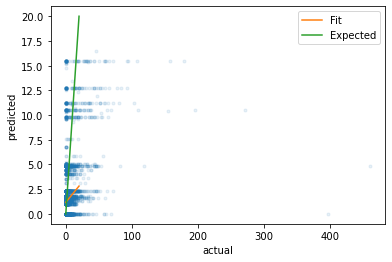

True: 5286
False: 2523
Precision: 0.4779892920880428
Recall: 0.6766315789473685
Correct rate: 0.6769112562427968
Fit: 0.0821180787762434, 1.17446786158726


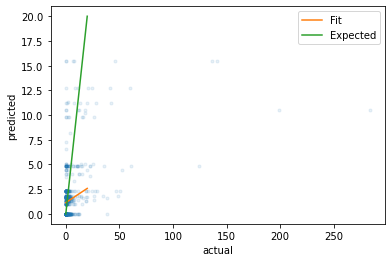

True: 610
False: 264
Precision: 0.5
Recall: 0.7121212121212122
Correct rate: 0.6979405034324943
Fit: 0.07183004327878198, 1.1450602630453164


In [22]:
def analyze_NN(model, X, Y):
    results = Y.flatten()
    pred = model.predict(X).flatten()
    
    slope, intercept, rvalue, pvalue, stderr = linregress(results,pred)

    plt.plot(results, pred, '.', alpha=0.1)
    xp = np.linspace(0,20, 100)
    plt.plot(xp, slope*xp + intercept, '-', label='Fit')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.plot(np.linspace(0,20, 100), np.linspace(0,20, 100), label='Expected')
    plt.legend()
    plt.show()
    
    

    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i in range(len(results)):
        res = results[i]
        predict = pred[i]
        if res > 0 and predict >= 0.5:
            true_positive += 1
        elif res <= 0 and predict < 0.5:
            true_negative += 1
        elif res > 0 and predict < 0.5:
            false_negative += 1
        else:
            false_positive += 1

    print("True: " + str(true_positive+true_negative))
    print("False: " + str(false_positive+false_negative))
    print("Precision: " +str(true_positive/(true_positive+false_positive)))
    print("Recall: " + str(true_positive/(true_positive+false_negative)))
    print("Correct rate: " + str((true_positive + true_negative)/len(results)))
    print("Fit: " + str(slope) +", " + str(intercept))

analyze_NN(model, X_train, y_train)
analyze_NN(model, X_test, y_test)

In [13]:
xg1 = XGBRegressor(max_depth=20, tree_method='gpu_hist', verbosity=1)
params = {'learning_rate': 0.49549618632767833, 'min_split_loss': 2.4026321003867816e-06, 'reg_lambda': 755.9066153776837, 'reg_alpha': 2.7376228157000275, 'min_child_weight': 8.58563354092164, 'max_delta_step': 1.1984765636612025}

X_train2, X_test2 = (np.array([x.flatten() for x in X_train]), np.array([x.flatten() for x in X_test]))

xg1.set_params(**params)
xg1 = MultiOutputRegressor(xg1)
xg1.fit(X_train2, y_train)

C:\Users\IntegralBery\anaconda3\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.49549618632767833,
                                            max_delta_step=1.1984765636612025,
                                            max_depth=20,
                                            min_child_weight=8.58563354092164,
                                            min_split_loss=2.4026321003867816e-06,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_esti

In [11]:
space  = [Real(10**-3, 1, "log-uniform", name='learning_rate'),
          Real(10**-9, 1, "log-uniform", name='min_split_loss'),
          Real(1, 10**5, "log-uniform", name='reg_lambda'),
          Real(1, 10**5, "log-uniform", name='reg_alpha'),
          Real(0, 20, name='min_child_weight'),
          Real(0, 10, name='max_delta_step')
         ]

xg1 = XGBRegressor(max_depth=20, tree_method='gpu_hist')
@use_named_args(space)
def objective(**params):
    xg1.set_params(**params)
    xg = MultiOutputRegressor(xg1)
    print(params)
    #xg1.fit(X1_train, Y1_train)
    #results = xg1.predict(X1_test)
    #actual = Y1_c_test
    return -np.mean(cross_val_score(xg, X_train2, y_train, cv=3, n_jobs=-1,
                                    scoring="r2"))

res_gp = gp_minimize(objective, space, n_calls=60, random_state=65, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
{'learning_rate': 0.4051466019912931, 'min_split_loss': 0.0009592216175698628, 'reg_lambda': 75.7747254516631, 'reg_alpha': 125.83804646352566, 'min_child_weight': 11.407257789813016, 'max_delta_step': 6.419958747872245}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 67.2918
Function value obtained: 0.0723
Current minimum: 0.0723
Iteration No: 2 started. Evaluating function at random point.
{'learning_rate': 0.0022498342531592345, 'min_split_loss': 0.38464333325880223, 'reg_lambda': 193.87638357187996, 'reg_alpha': 7070.459499443872, 'min_child_weight': 0.6411170222930852, 'max_delta_step': 6.442575166686249}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 43.3327
Function value obtained: 0.2876
Current minimum: 0.0723
Iteration No: 3 started. Evaluating function at random point.
{'learning_rate': 0.39064145435450065, 'min_split_loss': 4.573227209362603e-07, 'reg_lambda': 6.0462349118

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 428.6543
Function value obtained: -0.1055
Current minimum: -0.1321
Iteration No: 21 started. Searching for the next optimal point.
{'learning_rate': 0.10010190458848242, 'min_split_loss': 4.572458992229577e-07, 'reg_lambda': 1.0, 'reg_alpha': 10.086490781722452, 'min_child_weight': 0.0, 'max_delta_step': 10.0}
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 300.3461
Function value obtained: -0.0779
Current minimum: -0.1321
Iteration No: 22 started. Searching for the next optimal point.
{'learning_rate': 1.0, 'min_split_loss': 6.837617114281572e-07, 'reg_lambda': 1.0, 'reg_alpha': 100000.0, 'min_child_weight': 19.602208238447606, 'max_delta_step': 3.142076734568979}
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 44.2657
Function value obtained: 0.2876
Current minimum: -0.1321
Iteration No: 23 started. Searching for the next optimal point.
{'lea

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 99.0049
Function value obtained: -0.0720
Current minimum: -0.1388
Iteration No: 42 started. Searching for the next optimal point.
{'learning_rate': 1.0, 'min_split_loss': 1.0, 'reg_lambda': 4686.19760107124, 'reg_alpha': 8.743145522625762, 'min_child_weight': 20.0, 'max_delta_step': 8.650897346918612}
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 76.3978
Function value obtained: -0.1021
Current minimum: -0.1388
Iteration No: 43 started. Searching for the next optimal point.
{'learning_rate': 0.22956957257734184, 'min_split_loss': 8.67823264421061e-05, 'reg_lambda': 49.50553372178201, 'reg_alpha': 7.2955142292916, 'min_child_weight': 20.0, 'max_delta_step': 10.0}
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 166.9611
Function value obtained: -0.1050
Current minimum: -0.1388
Iteration No: 44 started. Searching for the next optimal point.
{'le

In [12]:
from skopt import dump, load

dump(res_gp, 'random_seed65.pkl')

In [16]:
np.linspace(0.1, 10, 100)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])

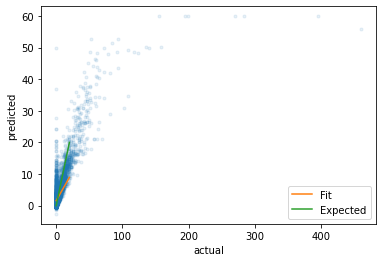

Fit: 0.36819618725297404, 1.5611397238999918 0.6097432657082094


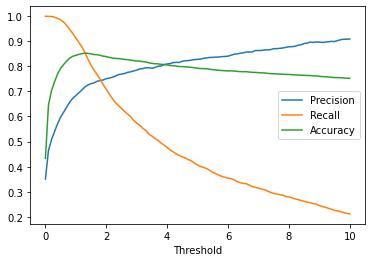

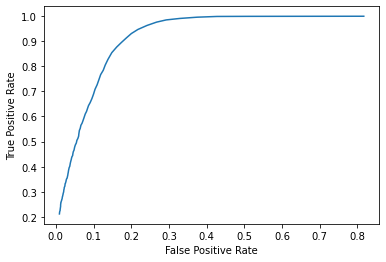

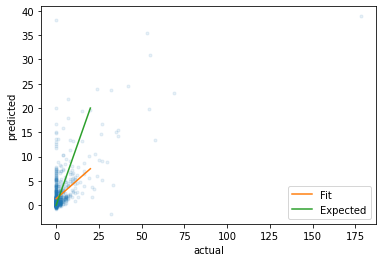

Fit: 0.3083849139404401, 1.3390312822197639 0.4277862225817096


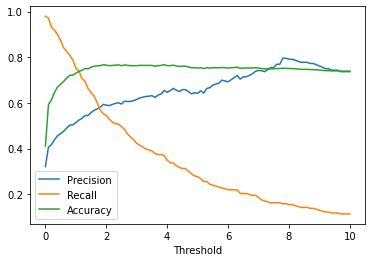

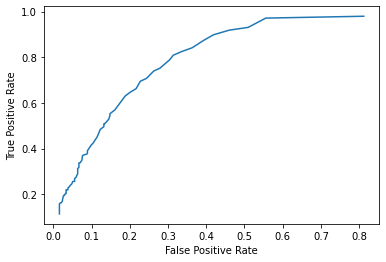

In [24]:
def analyze(model, X, Y):
    results = Y.flatten()
    pred = model.predict(X).flatten()
    
    slope, intercept, rvalue, pvalue, stderr = linregress(results,pred)
    fig = plt.figure()
    plt.plot(results, pred, '.', alpha=0.1)
    xp = np.linspace(0,20, 100)
    plt.plot(xp, slope*xp + intercept, '-', label='Fit')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.plot(np.linspace(0,20, 100), np.linspace(0,20, 100), label='Expected')
    plt.legend()
    plt.show()
    print("Fit: " + str(slope) +", " + str(intercept), rvalue**2)
    
    precisions = []
    recalls = []
    accuracy = []
    true_p = []
    false_p = []
    for i in np.linspace(0, 10, 101):
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0

        for s in range(len(results)):
            res = results[s]
            predict = pred[s]
            if res > 0 and predict >= i:
                true_positive += 1
            elif res <= 0 and predict < i:
                true_negative += 1
            elif res > 0 and predict < i:
                false_negative += 1
            else:
                false_positive += 1
        precisions.append(true_positive/(true_positive+false_positive))
        recalls.append(true_positive/(true_positive+false_negative))
        accuracy.append((true_positive + true_negative)/len(results))
        true_p.append(true_positive/(true_positive+false_negative))
        false_p.append(false_positive/(true_negative+false_positive))
        
        
    fig2 = plt.figure()
    plt.plot(np.linspace(0, 10, 101), precisions, label='Precision')
    plt.plot(np.linspace(0, 10, 101), recalls, label='Recall')
    plt.plot(np.linspace(0, 10, 101), accuracy, label='Accuracy')
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()
    
    fig3 = plt.figure()
    plt.plot(false_p, true_p)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    

analyze(xg1, X_train2, y_train)
analyze(xg1, X_test2, y_test)